In [1]:
#### The code is just a demo of how to use tensorflow functional API for Transfer learning task
#### We are going to use the architecture of the pre-trained MobileNetV2 model (all layers except the last layer)
#### Infact lets just use the weights also from the pretrained model

### We will use the Dogs Vs Cat dataset from a kaggle competition (https://www.kaggle.com/c/dogs-vs-cats/data). 
### However, since this is just a demo, I will limit it to 600 train, 300 val and 300 test samples 

In [2]:
#### Import all the required libraries

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [3]:
### Load and preprocess the data
images_train = np.load('data/images_train.npy') / 255.
images_valid = np.load('data/images_valid.npy') / 255.
images_test = np.load('data/images_test.npy') / 255.

labels_train = np.load('data/labels_train.npy')
labels_valid = np.load('data/labels_valid.npy')
labels_test = np.load('data/labels_test.npy')

In [4]:
### check the sample sizes
print('Number of samples in train are {}'.format(images_train.shape[0]))
print('Number of samples in Val are {}'.format(images_valid.shape[0]))
print('Number of samples in Test are {}'.format(images_test.shape[0]))

print('****************************************')

print('The input shape is {}'.format(images_train[0].shape))

Number of samples in train are 600
Number of samples in Val are 300
Number of samples in Test are 300
****************************************
The input shape is (160, 160, 3)


In [5]:
#### MobileNetV2 uses a (224x224x3) image and hence lets change the image size

images_train1 = image.smart_resize(images_train, size = (224,224))
images_valid1 = image.smart_resize(images_valid, size = (224,224))
images_test1 = image.smart_resize(images_test, size = (224,224))

print('new image size is {}'.format(images_train1[0].shape))

new image size is (224, 224, 3)


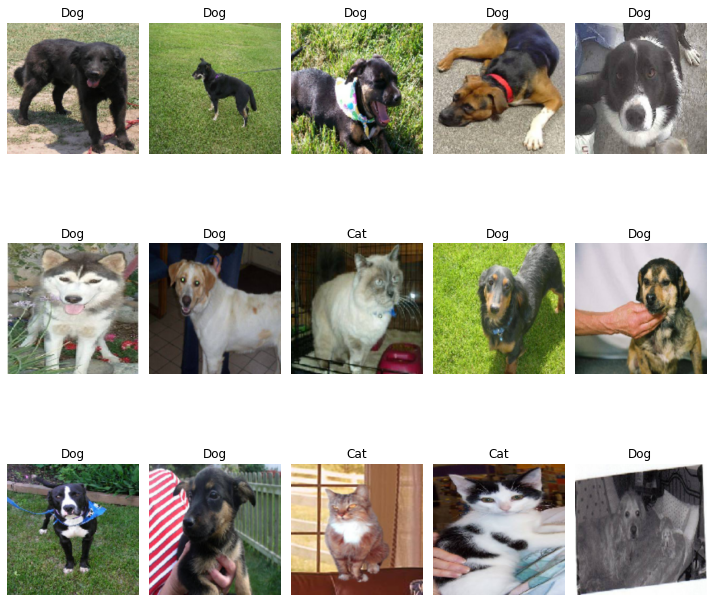

In [6]:
### Lets Display some of the sample images from the train data
np.random.seed(0)
random_list = random.sample(range(images_train1.shape[0]), 15)

random_list = np.array(random_list).reshape(3,5)

class_names = np.array(['Dog', 'Cat'])

fig, ax = plt.subplots(3,5, figsize = (10,10))

for i in range(3):
    for j in range(5):
        ax[i, j].set_axis_off()
        ax[i,j].imshow(images_train1[random_list[i,j]])
        ax[i,j].set_title(class_names[labels_train[random_list[i,j]]])
fig.tight_layout()
plt.show()

In [7]:
### Import the pretrained MobilenetV2 model from tensorflow.keras.applications

from tensorflow.keras.applications import mobilenet_v2

In [8]:
pretrained_model = mobilenet_v2.MobileNetV2()

In [9]:
### lets look at the different layers in the pretrained model

pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
### The pretrained model is based on the ImageNet data which has 1000 classes.
### However our data has only 2 classes hence we need to remove the output layer and make our our changes
### However lets try to make the most of the MobileNetV2 model and use all the other layers (and their weights)

input1 = pretrained_model.input ### Our input has the same shape as the ImageNetV2 model

output_pretrained = pretrained_model.get_layer('global_average_pooling2d').output ## output of the 2nd last layer is the output we need

### Create a new model with the above input and output
model_intermediate = Model(inputs = input1, outputs = output_pretrained)

### Since we want to use the weights from the pretrained model. Lets make the weights non-trainable
model_intermediate.trainable = False

### Print the model summary and check that none of the weights are trainable

model_intermediate.summary()

##Trainable_params = 0



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
### Now lets create some additional layers of our own

###using the input and output tensors from the intermediate model
input_final = model_intermediate.input
h =  model_intermediate.output

### Adding our own layers
h = Dense(32, activation = 'relu', trainable = True)(h)
h = Dropout(0.5)(h) ### Adding a dropout layer to prevent overfitting
h = Dense(1, activation = 'sigmoid', trainable = True)(h)

final_model = Model(inputs = input_final, outputs = h)

final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [12]:
### compile the model
##using RMSProp optimizer with learning rate = 0.001
final_model.compile(optimizer = tf.keras.optimizers.RMSprop(0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
###Train the model
# Train the model and save its training history
###Using early stopping to prevent overfitting

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_final = final_model.fit(images_train1, labels_train, epochs=10, batch_size=32,
                                                validation_data=(images_valid1, labels_valid), 
                                                callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 14s 611ms/step - loss: 0.2650 - accuracy: 0.8967 - val_loss: 0.0917 - val_accuracy: 0.9700
Epoch 2/10
19/19 [==============================] - 11s 575ms/step - loss: 0.1376 - accuracy: 0.9450 - val_loss: 0.0717 - val_accuracy: 0.9767
Epoch 3/10
19/19 [==============================] - 11s 572ms/step - loss: 0.1157 - accuracy: 0.9600 - val_loss: 0.1002 - val_accuracy: 0.9633
Epoch 4/10
19/19 [==============================] - 11s 576ms/step - loss: 0.0797 - accuracy: 0.9717 - val_loss: 0.0709 - val_accuracy: 0.9800
Epoch 5/10
19/19 [==============================] - 11s 575ms/step - loss: 0.0418 - accuracy: 0.9883 - val_loss: 0.0852 - val_accuracy: 0.9767
Epoch 6/10
19/19 [==============================] - 11s 578ms/step - loss: 0.0526 - accuracy: 0.9767 - val_loss: 0.1139 - val_accuracy: 0.9633


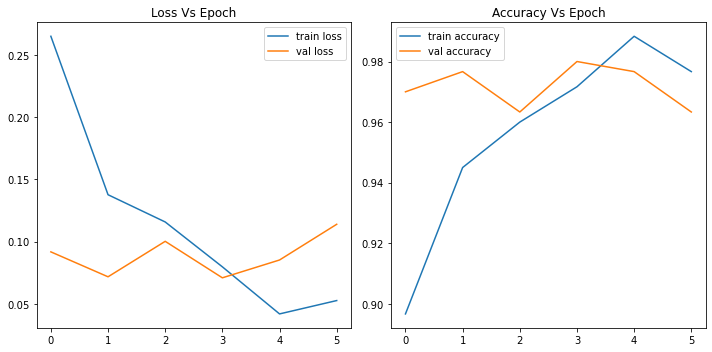

In [14]:
### Lets plot the Loss and the accuracy for Train and Validation

df = pd.DataFrame(history_final.history)
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(df.index, df['loss'])
ax[0].plot(df.index, df['val_loss'])
ax[0].legend(['train loss', 'val loss'])
ax[0].set_title('Loss Vs Epoch')
ax[1].plot(df.index,df['accuracy'])
ax[1].plot(df.index, df['val_accuracy'])
ax[1].legend(['train accuracy', 'val accuracy'])
ax[1].set_title('Accuracy Vs Epoch')
fig.tight_layout()
plt.show()

In [15]:
### Finally evaluate the model on the test data

final_model_test_loss, final_model_test_acc = final_model.evaluate(images_test1, labels_test, verbose=0)
print("Test loss: {}".format(final_model_test_loss))
print("Test accuracy: {}".format(final_model_test_acc))

Test loss: 0.09233435243368149
Test accuracy: 0.9566666483879089


In [ ]:
#### We got a pretty decent model with minimal effort! All thanks to Transfer Learning!! :) 
### Alwyas check Tensorflow.keras.applications to find models which you might want to use for your purposes
